<a href="https://colab.research.google.com/github/Kavyakav90/All-UK-House-Price-Prediction/blob/main/UK_houseprice_PR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import shap
import joblib
import os
from flask import Flask, request, jsonify

In [ ]:
# Load original dataset for visualization
df= pd.read_csv("UK-HPI-full-file-2024-01 (1).csv")

In [ ]:
# Convert 'Date' to DateTime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [ ]:
# Select relevant columns
columns_to_keep = [
    'Date', 'RegionName', 'AveragePrice', 'SalesVolume',
    'DetachedPrice', 'SemiDetachedPrice', 'TerracedPrice', 'FlatPrice',
    '1m%Change', '12m%Change', 'NewPrice', 'OldPrice'
]
df = df[columns_to_keep]

In [ ]:
# Handling missing values
df.fillna(df.median(numeric_only=True), inplace=True)  # Numeric columns
df.fillna(df.mode().iloc[0], inplace=True)  # Categorical columns

In [ ]:
df.isnull().sum()

,0
Date,0
RegionName,0
AveragePrice,0
SalesVolume,0
DetachedPrice,0
SemiDetachedPrice,0
TerracedPrice,0
FlatPrice,0
1m%Change,0
12m%Change,0


In [ ]:
df.describe()

,Date,AveragePrice,SalesVolume,DetachedPrice,SemiDetachedPrice,TerracedPrice,FlatPrice,1m%Change,12m%Change,NewPrice,OldPrice
count,139770,1.397700e+05,139770.000000,1.397700e+05,1.397700e+05,1.397700e+05,1.397700e+05,139770.000000,139770.000000,1.397700e+05,1.397700e+05
mean,2009-03-11 16:25:37.359948544,1.765359e+05,1225.607088,3.101864e+05,1.985533e+05,1.572562e+05,1.199170e+05,0.548325,6.399810,2.091374e+05,1.772585e+05
min,1968-04-01 00:00:00,2.712016e+03,2.000000,4.064610e+04,2.571306e+04,2.045985e+04,1.619875e+04,-30.297781,-35.786566,2.722990e+04,2.278638e+04
25%,2002-04-01 00:00:00,9.912619e+04,144.000000,1.757544e+05,1.093981e+05,8.574394e+04,7.028625e+04,-0.437792,1.545044,1.319326e+05,1.052103e+05
50%,2009-09-01 00:00:00,1.528433e+05,218.000000,2.474836e+05,1.552847e+05,1.246359e+05,1.013139e+05,0.500000,5.500000,1.901353e+05,1.536926e+05
75%,2016-11-01 00:00:00,2.224041e+05,373.000000,3.567567e+05,2.264596e+05,1.842176e+05,1.426731e+05,1.481231,10.311503,2.571894e+05,2.174949e+05
max,2024-01-01 00:00:00,1.527601e+06,183411.000000,4.494141e+06,4.513078e+06,2.960397e+06,1.312071e+06,35.286646,98.437940,1.313572e+06,1.539796e+06
std,NaN,1.206547e+05,7619.706425,2.702974e+05,2.062744e+05,1.507327e+05,9.183978e+04,1.961641,8.618436,1.212231e+05,1.173835e+05


In [ ]:
# Selecting top 10 regions with highest average house prices
top_regions = df.groupby('RegionName')['AveragePrice'].mean().nlargest(10).index
df_top_regions = df[df['RegionName'].isin(top_regions)]

In [ ]:
top_regions=df_top_regions

In [ ]:
top_regions

,Date,RegionName,AveragePrice,SalesVolume,DetachedPrice,SemiDetachedPrice,TerracedPrice,FlatPrice,1m%Change,12m%Change,NewPrice,OldPrice
16995,1995-01-01,Camden,120932.8881,198.0,4.069179e+05,2.485370e+05,164590.2482,111907.3581,0.500000,5.5,111178.3132,121827.3139
16996,1995-02-01,Camden,119508.8622,194.0,3.971958e+05,2.453630e+05,163282.4758,110530.9415,-1.177534,5.5,110596.9104,120366.2744
16997,1995-03-01,Camden,120282.2131,207.0,3.991010e+05,2.463659e+05,164315.1482,111277.8361,0.647108,5.5,111699.1498,121131.1498
16998,1995-04-01,Camden,120097.8990,174.0,3.933858e+05,2.450769e+05,164119.2417,111171.2365,-0.153235,5.5,111506.6651,120946.3168
16999,1995-05-01,Camden,119929.2782,220.0,3.928075e+05,2.455692e+05,164171.9180,110936.3949,-0.140403,5.5,111238.0069,120780.5625
...,...,...,...,...,...,...,...,...,...,...,...,...
126077,2023-09-01,Wandsworth,625137.0000,382.0,1.910579e+06,1.298028e+06,902527.0000,517013.0000,1.800000,-3.2,631743.0000,632095.0000
126078,2023-10-01,Wandsworth,625387.0000,321.0,1.893840e+06,1.294361e+06,901275.0000,517962.0000,0.000000,-2.4,641933.0000,631982.0000
126079,2023-11-01,Wandsworth,631448.0000,217.0,1.896355e+06,1.302754e+06,906274.0000,524372.0000,1.000000,0.3,665035.0000,637531.0000
126080,2023-12-01,Wandsworth,611819.0000,218.0,1.776148e+06,1.244858e+06,870443.0000,511465.0000,-3.100000,-2.0,190135.2837,153692.5678


In [ ]:
#splitting the datat
# Sort the dataset by Date
df_sorted = df.sort_values(by='Date').reset_index(drop=True)

# Define the split point (80% train, 20% test)
split_index = int(len(df_sorted) * 0.8)

# Time-based train/test split
train_set = df_sorted.iloc[:split_index]
test_set = df_sorted.iloc[split_index:]

# Split features and target
X_train = train_set.drop(columns=['AveragePrice'])
y_train = train_set['AveragePrice']
X_test = test_set.drop(columns=['AveragePrice'])
y_test = test_set['AveragePrice']

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")


Train set: (111816, 11), Test set: (27954, 11)


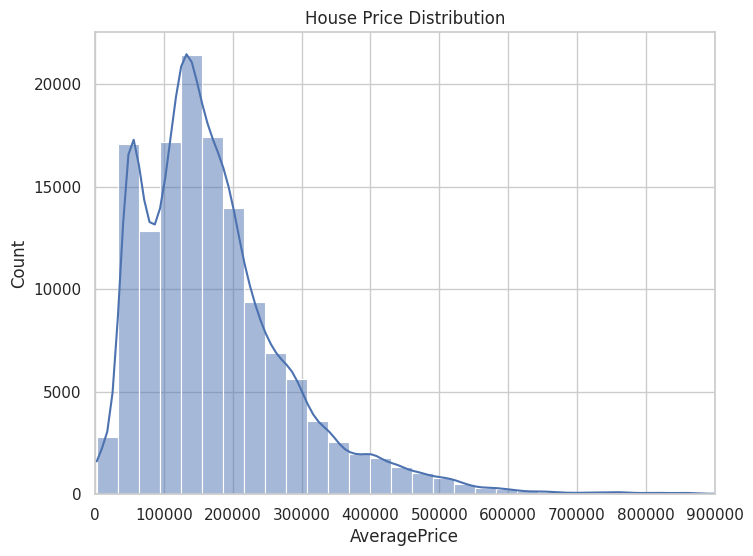

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df,x='AveragePrice',bins=50,kde=True)
plt.xlim(0,900000)
plt.title("House Price Distribution")
plt.xlabel("AveragePrice")
plt.ylabel("Count")
plt.show()

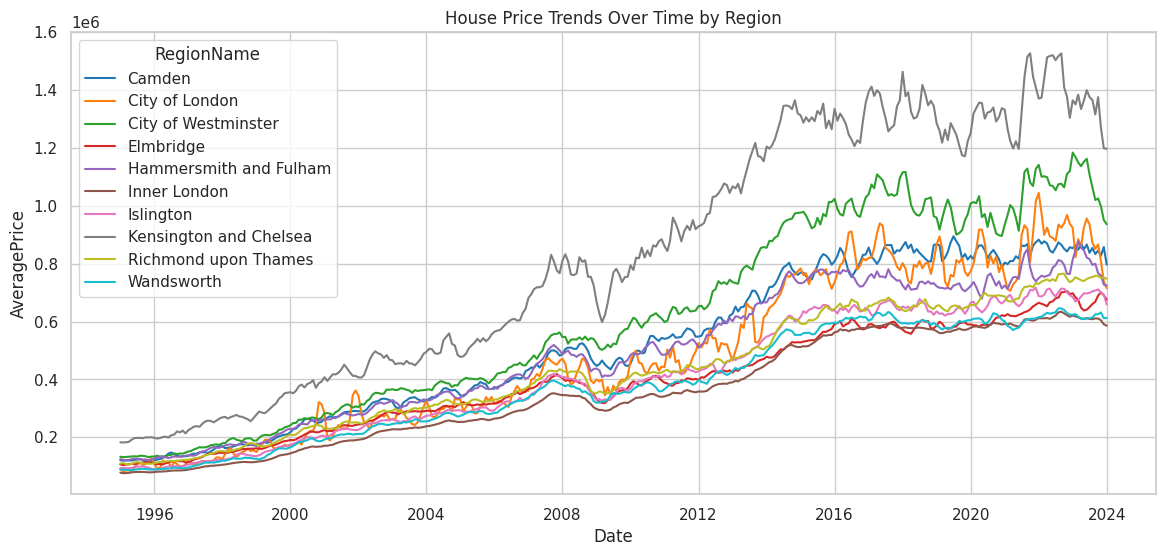

In [ ]:
# 2. House Price Trends Over Time by Region
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='AveragePrice', data=top_regions, hue='RegionName', palette='tab10')
plt.title("House Price Trends Over Time by Region")
plt.show()

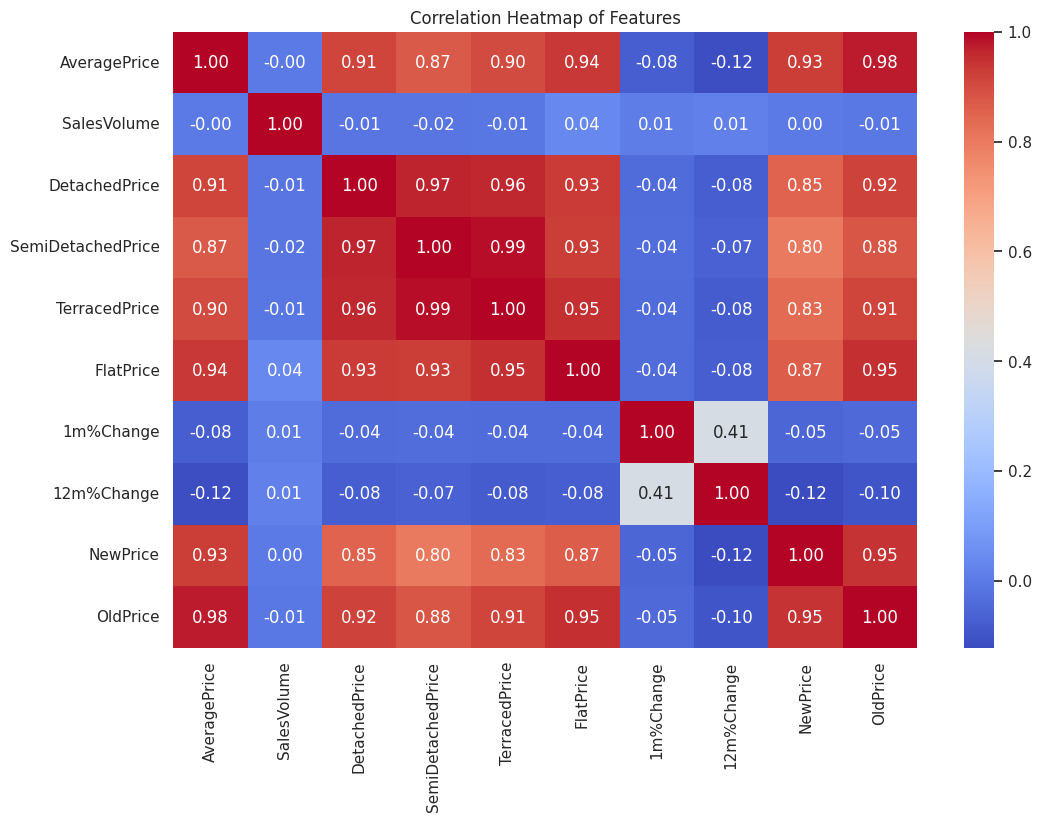

In [ ]:
# 3. Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap of Features")
plt.show()

<ipython-input-51-fae52b3f7512>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='RegionName', y='AveragePrice', data=df_top_regions, palette='coolwarm')


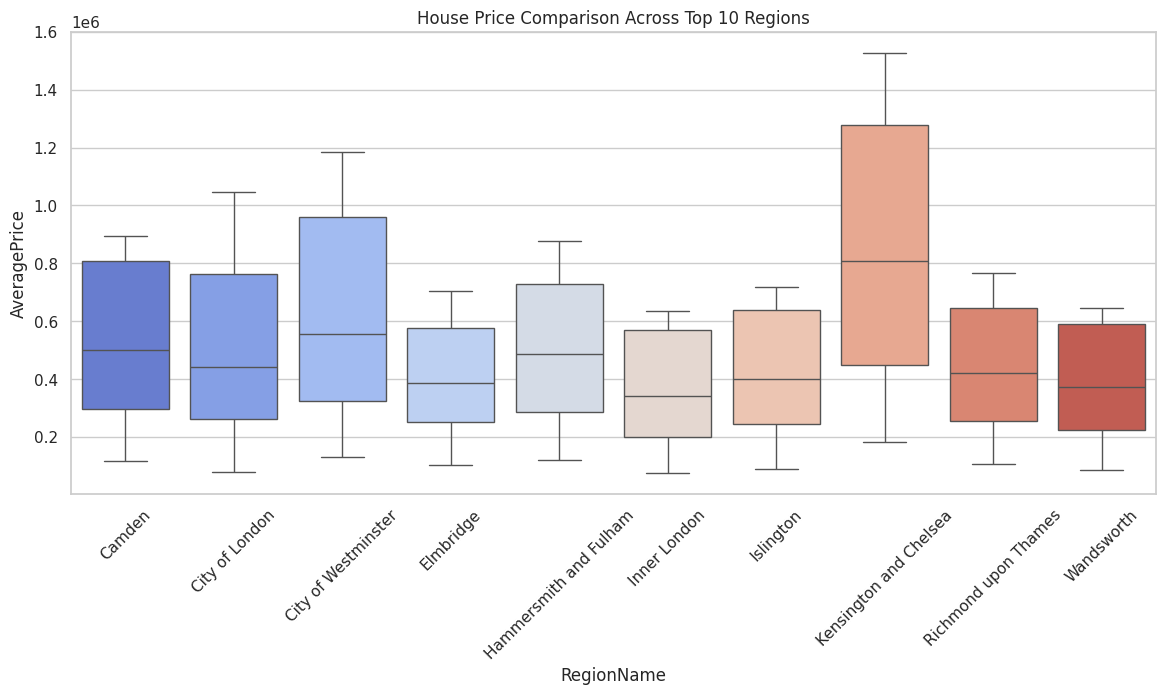

In [ ]:
# 4. Boxplot Comparison for Property Types in Top 10 Regions
plt.figure(figsize=(14, 6))
sns.boxplot(x='RegionName', y='AveragePrice', data=df_top_regions, palette='coolwarm')
plt.xticks(rotation=45)
plt.title("House Price Comparison Across Top 10 Regions")
plt.show()

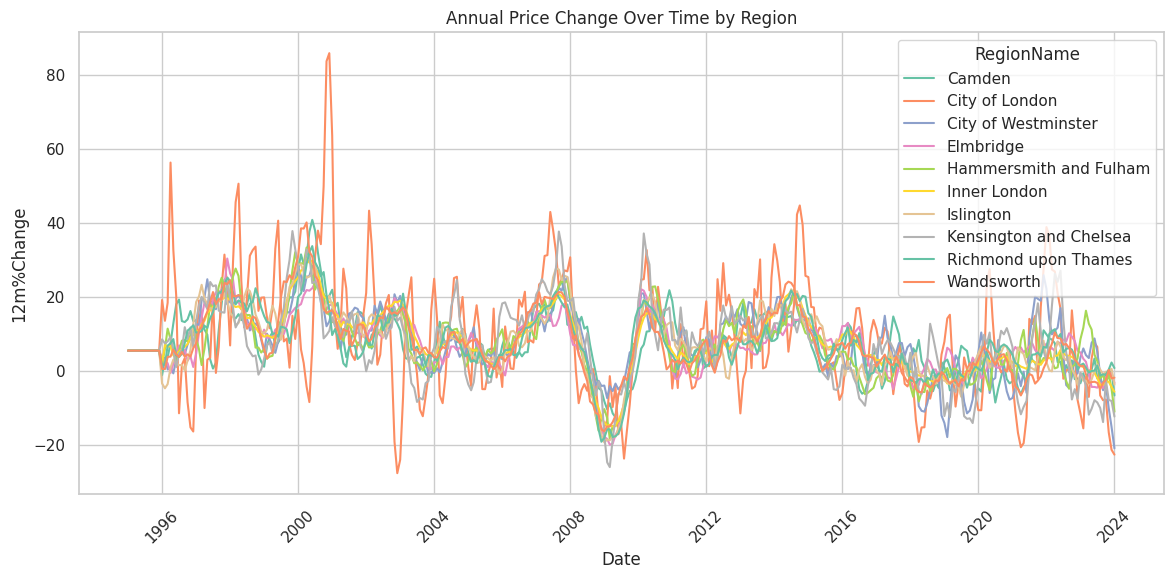

In [ ]:
# 6. Annual Price Change Over Time
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='12m%Change', data=top_regions, hue='RegionName', palette='Set2')
plt.title("Annual Price Change Over Time by Region")
plt.xticks(rotation=45)
plt.show()

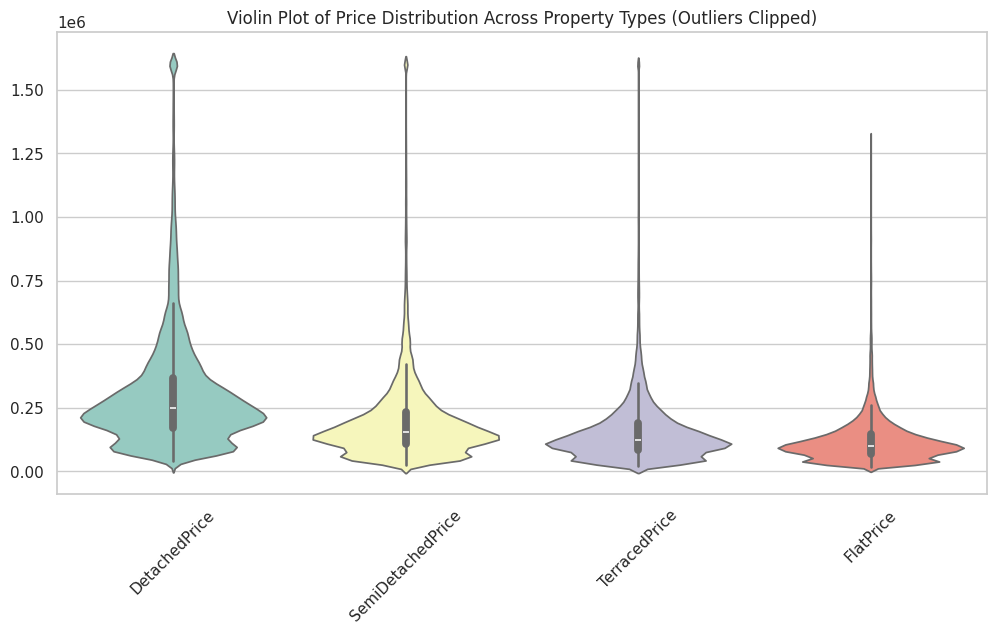

In [ ]:
# 7. Violin Plot for Property Type Price Distribution
df_clipped = df[['DetachedPrice', 'SemiDetachedPrice', 'TerracedPrice', 'FlatPrice']].clip(upper=1.6e6)

plt.figure(figsize=(12, 6))
sns.violinplot(data=df_clipped, palette='Set3')
plt.title("Violin Plot of Price Distribution Across Property Types (Outliers Clipped)")
plt.xticks(rotation=45)
plt.show()


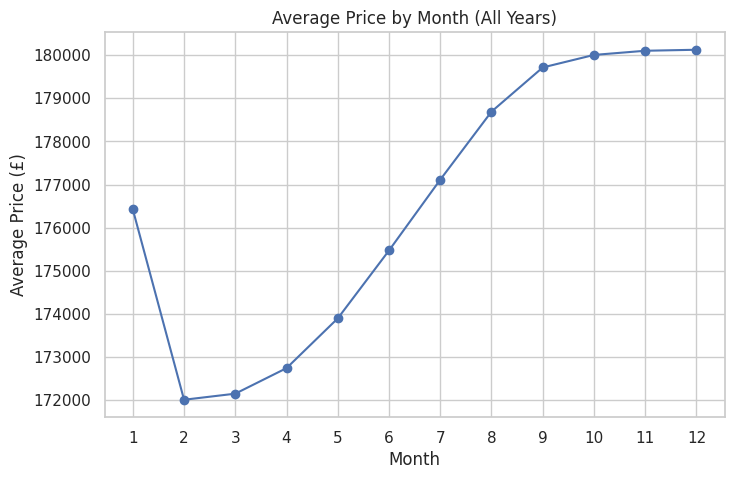

In [ ]:
monthly_avg = df.groupby(df['Date'].dt.month)['AveragePrice'].mean()

plt.figure(figsize=(8, 5))
monthly_avg.plot(marker='o')
plt.title('Average Price by Month (All Years)')
plt.xlabel('Month')
plt.ylabel('Average Price (£)')
plt.xticks(np.arange(1, 13))
plt.grid(True)
plt.show()


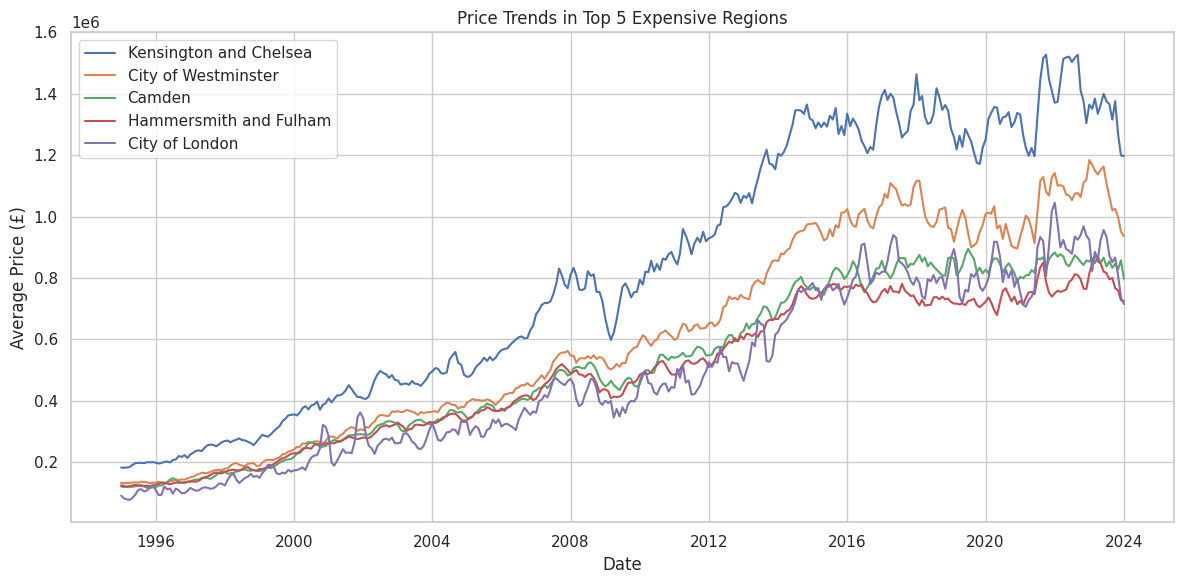

In [ ]:
top_5_regions = df.groupby('RegionName')['AveragePrice'].mean().sort_values(ascending=False).head(5).index
plt.figure(figsize=(12, 6))
for region in top_5_regions:
    regional_data = df[df['RegionName'] == region]
    sns.lineplot(x='Date', y='AveragePrice', data=regional_data, label=region)

plt.title('Price Trends in Top 5 Expensive Regions')
plt.xlabel('Date')
plt.ylabel('Average Price (£)')
plt.legend()
plt.tight_layout()
plt.show()


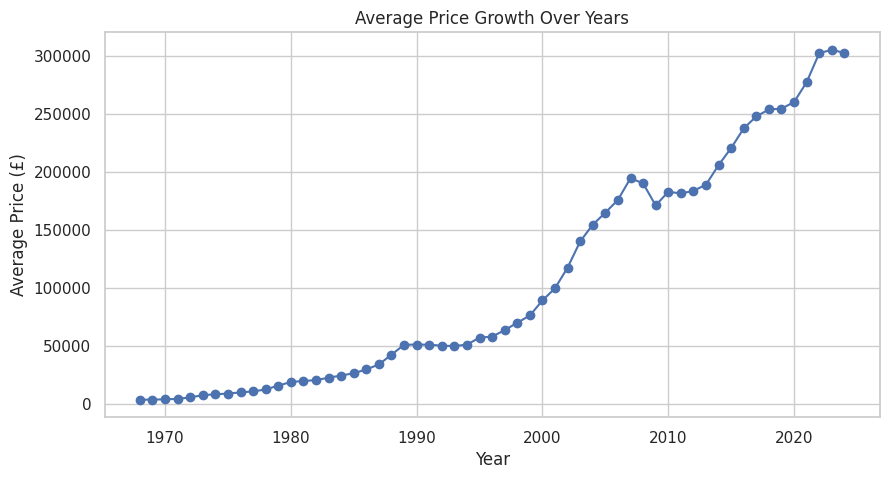

In [ ]:
yearly_avg = df.groupby(df['Date'].dt.year)['AveragePrice'].mean()

plt.figure(figsize=(10, 5))
yearly_avg.plot(marker='o')
plt.title("Average Price Growth Over Years")
plt.xlabel("Year")
plt.ylabel("Average Price (£)")
plt.grid(True)
plt.show()


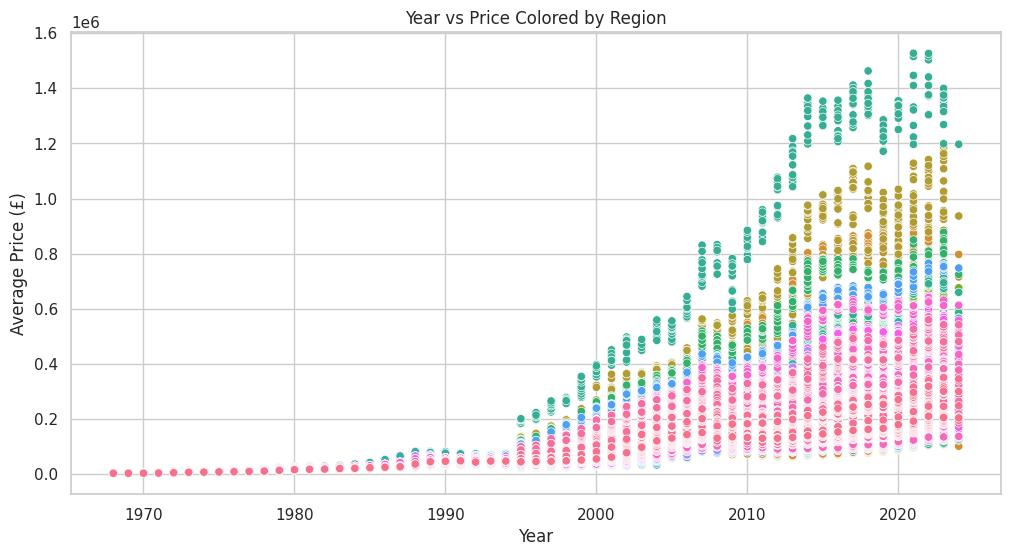

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x=df['Date'].dt.year, y='AveragePrice', hue='RegionName', legend=False)
plt.title('Year vs Price Colored by Region')
plt.xlabel('Year')
plt.ylabel('Average Price (£)')
plt.show()


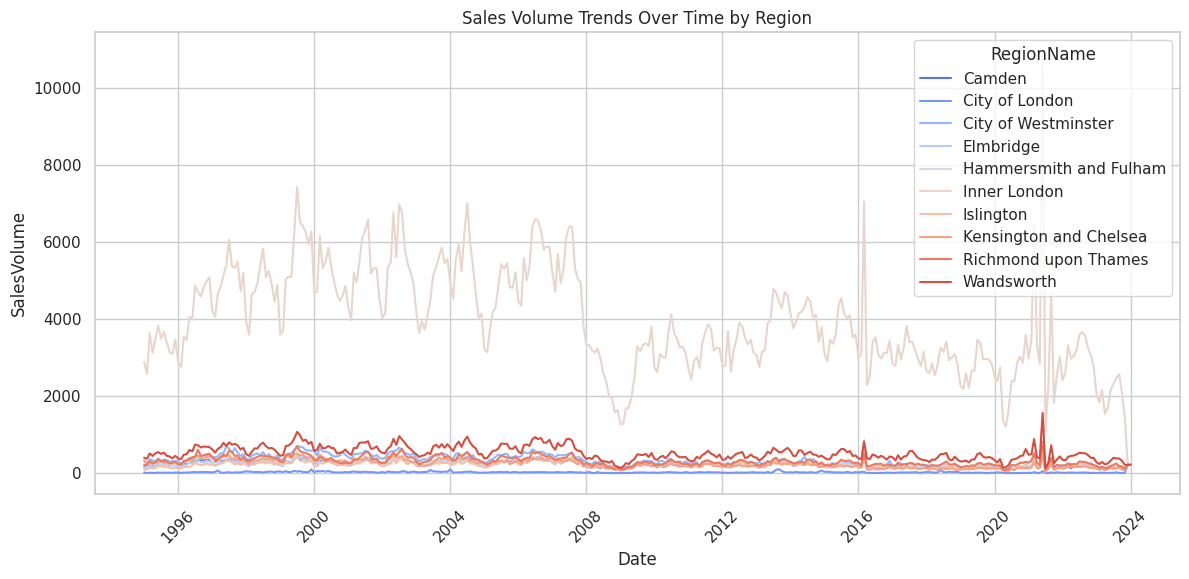

In [ ]:
# 8. Sales Volume Trends Over Time
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='SalesVolume', data=top_regions, hue='RegionName', palette='coolwarm')
plt.title("Sales Volume Trends Over Time by Region")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Scaling numeric features
scaler = StandardScaler()
numeric_cols = ['AveragePrice', 'SalesVolume', 'DetachedPrice', 'SemiDetachedPrice',
                'TerracedPrice', 'FlatPrice', '1m%Change', '12m%Change', 'NewPrice', 'OldPrice']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


In [ ]:
# Encoding categorical variables (RegionName)
le = LabelEncoder()
df['RegionName'] = le.fit_transform(df['RegionName'])

In [ ]:
X = df.drop(columns=['AveragePrice', 'Date'])
y = df['AveragePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=2, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=50, random_state=42),
    "Support Vector Regression": SVR(kernel='rbf'),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

results = {}
if not os.path.exists("saved_models"):
    os.makedirs("saved_models")

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    try:
        cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1).mean()
    except:
        cross_val = None

    results[name] = {
        "R2 Score": r2_score(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred),
        "Cross-Val R2": cross_val
    }

    joblib.dump(model, f"saved_models/{name.replace(' ', '_').lower()}.pkl")


Training Linear Regression...
Training Ridge Regression...
Training Lasso Regression...
Training ElasticNet...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...
Training AdaBoost...
Training Support Vector Regression...
Training XGBoost...
